# IMPORTACIÓN DE MODULOS Y CARGA DE DATOS


In [63]:
import pandas as pd
import analisis
import numpy as np
import itertools
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 18, 8 # Definimos el tamaño de los gráficos para que se ajusten bien al notebook
plt.style.use('ggplot')
import quandl
import warnings
warnings.filterwarnings('ignore')

In [2]:
# from importlib import reload
# reload (analisis)

In [3]:

quandl.ApiConfig.api_key = "T2qLgEpkXT7w6Xwey18f"
qd_data = quandl.get("WIKI/AAPL", start_date= "2000-01-01", end_date= "2018-06-15")

In [4]:
# qd_data.to_pickle('disney_fromquandl.pkl')
# qd_data = pd.read_pickle('disney_fromquandl.pkl')

In [5]:
qd_data.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2000-01-03,104.87,112.50,101.69,111.94,4783900.0,0.0,1.0,3.369314,3.614454,3.267146,3.596463,133949200.0
2000-01-04,108.25,110.62,101.19,102.50,4574800.0,0.0,1.0,3.477908,3.554053,3.251081,3.293170,128094400.0
2000-01-05,103.75,110.56,103.00,104.00,6949300.0,0.0,1.0,3.333330,3.552125,3.309234,3.341362,194580400.0
2000-01-06,106.12,107.00,95.00,95.00,6856900.0,0.0,1.0,3.409475,3.437748,3.052206,3.052206,191993200.0
2000-01-07,96.50,101.00,95.50,99.50,4113700.0,0.0,1.0,3.100399,3.244977,3.068270,3.196784,115183600.0


In [6]:
ajustadas = [f for f in qd_data.columns if f.startswith('Adj')]
qd_data = qd_data[ajustadas].copy()
qd_data.columns = [f[5:] for f in qd_data.columns]
qd_data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-03,3.369314,3.614454,3.267146,3.596463,133949200.0
2000-01-04,3.477908,3.554053,3.251081,3.293170,128094400.0
2000-01-05,3.333330,3.552125,3.309234,3.341362,194580400.0
2000-01-06,3.409475,3.437748,3.052206,3.052206,191993200.0
2000-01-07,3.100399,3.244977,3.068270,3.196784,115183600.0


---

# OPTIMIZACION DEL SISTEMA

In [7]:
op_data = qd_data[:'2016'].copy()
op_data['Dif_Close'] = op_data.Close.pct_change()
op_data['Dif_Open'] = op_data.Open.pct_change()

In [8]:
def estrategia_medias (df, periodo_rapido, periodo_lento, separacion):
    
    estr = df.copy()
    estr[f'SMA_{periodo_rapido}'] = estr.Close.rolling(periodo_rapido).mean()
    estr[f'SMA_{periodo_lento}'] = estr.Close.rolling(periodo_lento).mean()
    estr['Dif_SMA'] = (estr[f'SMA_{periodo_rapido}'] - estr[f'SMA_{periodo_lento}']) / estr[f'SMA_{periodo_lento}']
      
    estr['Senal'] = (estr.Dif_SMA / estr.Dif_SMA.abs()) * (estr.Dif_SMA.abs() > separacion).fillna(0)
    estr['Posicion'] = estr.Senal.shift(1).fillna(0)   
    
    
    estr['Trade'] = np.NaN  
    estr.Trade = np.where((estr.Posicion.shift(-1) != 0) & (estr.Posicion != estr.Posicion.shift(1)), 
                      estr.index.year * 10000 + estr.index.month * 100 + estr.index.day, 
                          np.where((estr.Posicion.shift(1) != 0) & (estr.Posicion != estr.Posicion.shift(1)),
                                   0 ,np.NaN))    
    estr['Comision'] = 0
    estr['Comision'] = estr.Comision.mask(estr.Trade.shift(-1) == 0, 0.005)
    
    estr.Trade.ffill(inplace = True)
    estr.Trade.fillna(0, inplace = True)
       
    estr['Retornos'] = estr.Posicion.shift(1) * estr.Dif_Open - estr.Comision    
    estr['Capital'] = estr.Retornos.add(1).cumprod() * 100 
    
    parametros = {'Rapida' : periodo_rapido, 'Lenta' : periodo_lento, 'Separación' : separacion}                         
    resultados = resultado_estrategia(estr, parametros)
    
    return estr, resultados


def resultado_estrategia (estr, parametros):

    resultados = parametros
    resultados['Beneficio Bruto'] = round(estr.Capital[-1]-100,2)  
    resultados['CAGR'] = analisis.CAGR(estr.Retornos)     
    resultados['Máximo Drawdown'] = round((estr.Capital.div(estr.Capital.cummax()).sub(1)).min(),2)
   
    
    resultados['Número de trades'] = len(estr.Trade[estr.Trade>0].unique())
    trades = estr[estr.Trade != 0].groupby('Trade')
    
    resultados['MAE'] = (trades.Capital.min() - trades.Capital.first()).min()
    resultados['MFE'] = (trades.Capital.max() - trades.Capital.first()).max()
    
    trades_ret = ((trades.Capital.last()/trades.Capital.first()) - 1 ).dropna()

    resultados['Profit Factor'] = -trades_ret[trades_ret>0].sum()/trades_ret[trades_ret<=0].sum()
    resultados['Num Trades Ganadores'] = trades_ret[trades_ret>0].count()
    resultados['Num Trades Perdedores'] = trades_ret[trades_ret<=0].count()
    resultados['Ratio Acierto'] = round(100 * resultados['Num Trades Ganadores'] / resultados['Número de trades'], 2)
    
    resultados['Sharpe'] = round(analisis.sharpe_anual(trades_ret),3)
    
    return resultados

In [47]:
periodos_rapido = range (10,110,5)
periodos_lento = range (30,210,5)
separaciones = np.round(np.arange(0.01, 0.10, 0.01),2)

In [48]:
%%time

coleccion = {}
resultados = {}
parametros = itertools.product(*[periodos_rapido, periodos_lento, separaciones])


for par in parametros:
    periodo_rapido, periodo_lento, separacion = par   
    if periodo_lento <= periodo_rapido:
        continue
    estr, resultado = estrategia_medias (op_data, periodo_rapido, periodo_lento, separacion)
    nombre = f'estrategia_{periodo_rapido}_{periodo_lento}_{separacion}'
    coleccion[nombre] = estr
    resultados[nombre] = resultado


CPU times: user 1min 57s, sys: 480 ms, total: 1min 57s
Wall time: 1min 57s


In [49]:
print ('Realizados {} backtests sobre una serie de {} muestras'.format(len(coleccion), op_data.shape[0]))

Realizados 5256 backtests sobre una serie de 4277 muestras


In [50]:
clasificacion = pd.DataFrame(resultados).transpose()
clasificacion.head(25)

,Beneficio Bruto,CAGR,Lenta,MAE,MFE,Máximo Drawdown,Num Trades Ganadores,Num Trades Perdedores,Número de trades,Profit Factor,Rapida,Ratio Acierto,Separación,Sharpe
estrategia_10_30_0.01,19.12,0.010343,30.0,-42.771192,111.651194,-0.75,57.0,117.0,174.0,1.382125,10.0,32.76,0.01,1.372
estrategia_10_30_0.02,-62.63,-0.056241,30.0,-17.726928,39.768337,-0.80,47.0,94.0,141.0,1.165619,10.0,33.33,0.02,0.758
estrategia_10_30_0.03,-43.48,-0.033003,30.0,-16.989785,44.491148,-0.71,51.0,83.0,134.0,1.150677,10.0,38.06,0.03,0.689
estrategia_10_30_0.04,-54.52,-0.045284,30.0,-14.877678,30.823842,-0.73,38.0,70.0,108.0,1.121568,10.0,35.19,0.04,0.573
estrategia_10_30_0.05,-34.83,-0.024868,30.0,-9.861413,25.997196,-0.72,38.0,52.0,90.0,1.184627,10.0,42.22,0.05,0.888
estrategia_10_30_0.06,27.26,0.014278,30.0,-25.141683,67.437482,-0.53,27.0,40.0,67.0,1.352366,10.0,40.30,0.06,1.591
estrategia_10_30_0.07,-15.95,-0.010166,30.0,-11.505578,45.816352,-0.65,24.0,29.0,53.0,1.528182,10.0,45.28,0.07,2.414
estrategia_10_30_0.08,-19.78,-0.012878,30.0,-10.434445,38.871438,-0.54,20.0,25.0,45.0,1.608746,10.0,44.44,0.08,2.279
estrategia_10_30_0.09,27.26,0.014281,30.0,-12.645731,42.698802,-0.43,16.0,15.0,31.0,1.784154,10.0,51.61,0.09,2.903
estrategia_10_35_0.01,65.48,0.030068,35.0,-24.904535,76.050148,-0.70,57.0,95.0,152.0,1.579016,10.0,37.50,0.01,1.950


In [51]:
pd.DataFrame(clasificacion['Beneficio Bruto'].sort_values(ascending=False).head(10))

,Beneficio Bruto
estrategia_10_190_0.01,1394.89
estrategia_10_190_0.02,1372.92
estrategia_10_200_0.02,1264.58
estrategia_10_195_0.02,1228.00
estrategia_45_70_0.01,1226.80
estrategia_10_205_0.01,1223.38
estrategia_50_135_0.01,1201.41
estrategia_45_135_0.01,1149.98
estrategia_15_190_0.03,1143.54
estrategia_50_70_0.01,1117.75


In [52]:
pd.DataFrame(clasificacion.Sharpe.sort_values(ascending=False).head(10))

,Sharpe
estrategia_30_35_0.05,51.368
estrategia_40_45_0.04,26.663
estrategia_45_55_0.08,21.118
estrategia_45_55_0.07,17.825
estrategia_45_50_0.04,15.611
estrategia_50_55_0.04,12.889
estrategia_40_50_0.08,11.976
estrategia_50_60_0.07,11.878
estrategia_35_50_0.08,9.033
estrategia_45_60_0.09,8.075


In [53]:
pd.DataFrame(clasificacion['Máximo Drawdown'].sort_values(ascending = False).head(10))

,Máximo Drawdown
estrategia_105_110_0.08,0.00
estrategia_95_100_0.09,0.00
estrategia_100_105_0.09,0.00
estrategia_105_110_0.09,0.00
estrategia_90_95_0.09,-0.02
estrategia_100_105_0.08,-0.04
estrategia_95_100_0.08,-0.05
estrategia_100_105_0.07,-0.05
estrategia_50_55_0.04,-0.07
estrategia_50_55_0.05,-0.07


In [54]:
pd.DataFrame(clasificacion['Número de trades'].sort_values().head(10))


,Número de trades
estrategia_105_110_0.08,0.0
estrategia_105_110_0.09,0.0
estrategia_100_105_0.09,0.0
estrategia_95_100_0.09,0.0
estrategia_80_85_0.09,1.0
estrategia_95_110_0.09,1.0
estrategia_35_40_0.05,1.0
estrategia_35_40_0.06,1.0
estrategia_35_40_0.07,1.0
estrategia_85_95_0.09,1.0


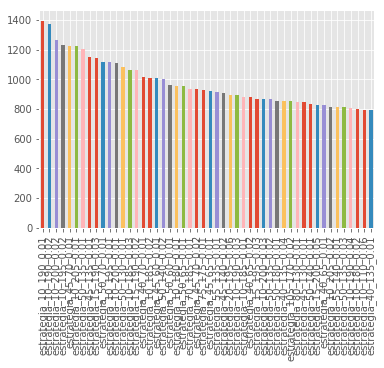

In [55]:
clasificacion['Beneficio Bruto'].sort_values(ascending=False).head(50).plot(kind='bar')

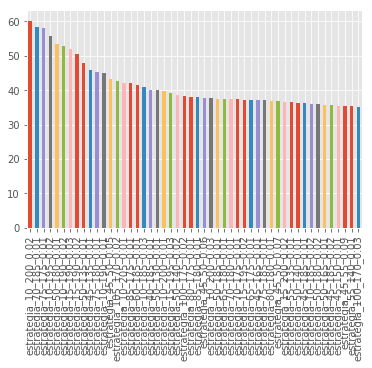

In [56]:
(clasificacion['Beneficio Bruto']/clasificacion['Número de trades']).sort_values(ascending=False).head(50).plot(kind='bar')

In [57]:
aptas = clasificacion[clasificacion['Número de trades']>20]

In [58]:
pd.DataFrame(aptas['Beneficio Bruto'].sort_values(ascending=False).head(10))

,Beneficio Bruto
estrategia_10_190_0.01,1394.89
estrategia_10_190_0.02,1372.92
estrategia_10_200_0.02,1264.58
estrategia_10_195_0.02,1228.00
estrategia_45_70_0.01,1226.80
estrategia_10_205_0.01,1223.38
estrategia_50_135_0.01,1201.41
estrategia_45_135_0.01,1149.98
estrategia_15_190_0.03,1143.54
estrategia_50_70_0.01,1117.75


In [59]:
pd.DataFrame(aptas['Máximo Drawdown'].sort_values(ascending=False).head(10))

,Máximo Drawdown
estrategia_55_65_0.03,-0.42
estrategia_15_30_0.07,-0.43
estrategia_10_30_0.09,-0.43
estrategia_30_55_0.07,-0.44
estrategia_15_75_0.09,-0.44
estrategia_50_60_0.01,-0.45
estrategia_10_70_0.08,-0.45
estrategia_45_65_0.06,-0.45
estrategia_25_55_0.08,-0.46
estrategia_40_70_0.03,-0.46


In [60]:
pd.DataFrame(aptas.Sharpe.sort_values(ascending=False).head(10))

,Sharpe
estrategia_50_135_0.01,5.572
estrategia_40_95_0.08,5.517
estrategia_50_150_0.01,5.505
estrategia_50_140_0.01,5.496
estrategia_55_135_0.01,5.496
estrategia_30_135_0.05,5.486
estrategia_40_150_0.01,5.481
estrategia_35_130_0.04,5.457
estrategia_45_135_0.01,5.421
estrategia_40_90_0.08,5.408


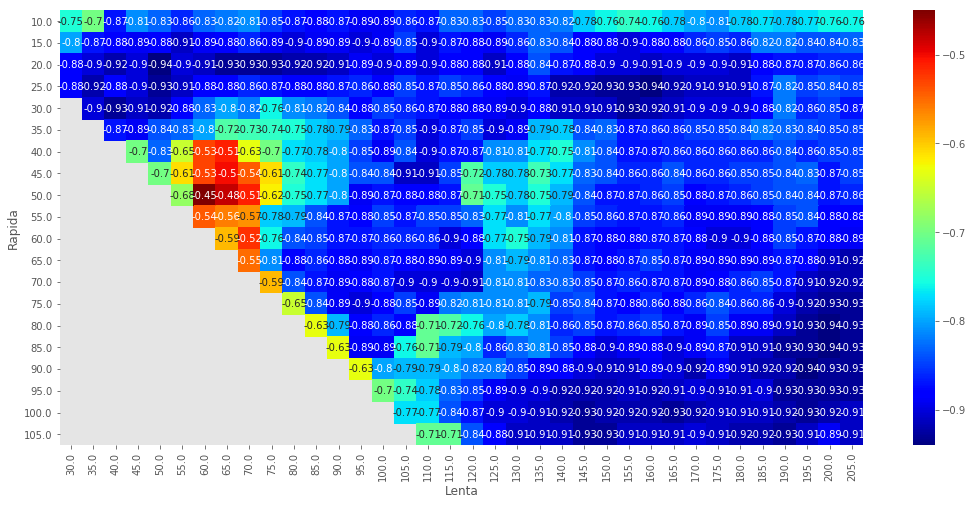

In [64]:
ax=sns.heatmap(clasificacion[clasificacion['Separación']==0.01].pivot('Rapida','Lenta','Máximo Drawdown'), annot=True, fmt=".3", linewidths=0, cmap=plt.cm.jet)

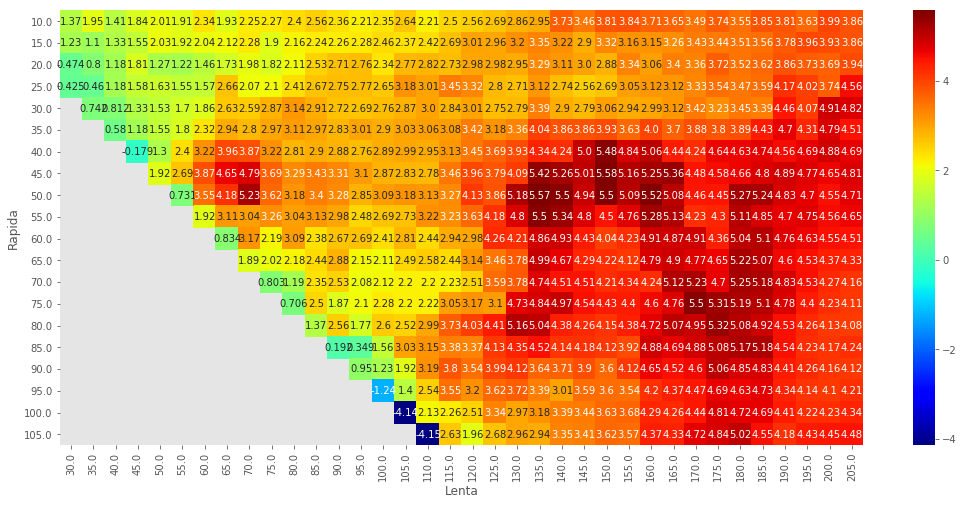

In [65]:
ax=sns.heatmap(clasificacion[clasificacion['Separación']==0.01].pivot('Rapida','Lenta','Sharpe'), annot=True, fmt=".3", linewidths=0, cmap=plt.cm.jet)

---

# REVISIÓN DE LOS PARÁMETROS SELECCIONADOS

In [66]:
pd.DataFrame(clasificacion.loc['estrategia_50_70_0.01'])

,estrategia_50_70_0.01
Beneficio Bruto,1117.750000
CAGR,0.158367
Lenta,70.000000
MAE,-245.565234
MFE,432.260234
Máximo Drawdown,-0.510000
Num Trades Ganadores,28.000000
Num Trades Perdedores,24.000000
Número de trades,52.000000
Profit Factor,3.150476


In [67]:
def grafico (df):
    estudio = df.copy()
    DD_bh, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Dif_Close[60:], info = False) 
    DD, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Retornos.fillna(0), info = False) 

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(18, 12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    fig.suptitle('Estrategia vs B & H', fontsize=20)

    ax1.plot(estudio.Capital.fillna(100))
    ax1.plot((estudio.Close) *100 / estudio.Close[0])
    ax1.set_title('Capital')
    ax1.legend(['Estrategia','Buy & Hold'])

    ax2.plot(DD*100, c='0.5')
    ax2.plot(DD_bh*100, c='y')
    ax2.fill_between(DD.index, 0, DD*100, color='0.7')
    ax2.set_title('Drawdown')
    ax2.legend(['Estrategia','Buy & Hold'])

    ax3.plot(estudio.Senal, c='orange')
    ax3.fill_between(estudio.index, 0, estudio.Senal*100, color='orange')
    ax3.set_title('Posición')

    plt.show()
    return

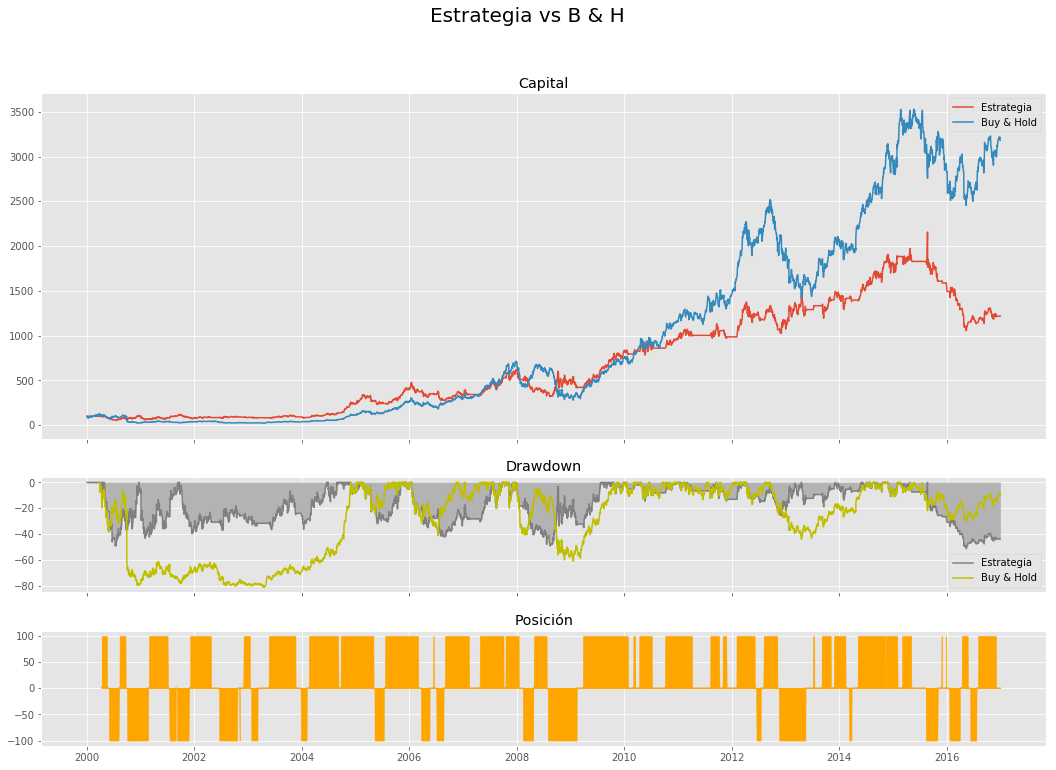

In [68]:
grafico(coleccion['estrategia_50_70_0.01'])


---


# PRUEBA FUERA DE LA MUESTRA

In [69]:
periodo_rapido = 50
periodo_lento = 70
separacion = 0.01

out_sample= qd_data[op_data.shape[0]:].copy()

out_sample['Dif_Close'] = out_sample.Close.pct_change()
out_sample['Dif_Open'] = out_sample.Open.pct_change()


out_estr, out_resultado = estrategia_medias (out_sample, periodo_rapido, periodo_lento, separacion)


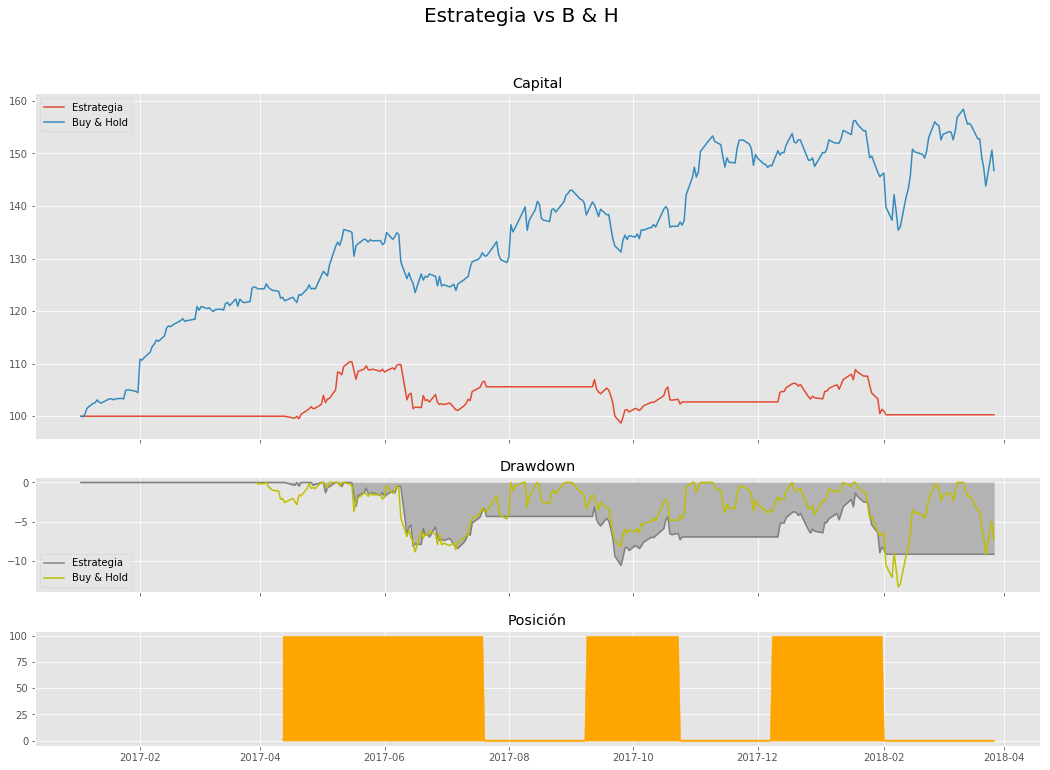

In [70]:
grafico(out_estr)

---